**Yudhistira Erlandinata – 1606894534**

Table of content

Who Left [here](#who-left)

Russian House Pricing [here](#russian-house-pricing)

Movies [here](#movies)

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.tree import export_graphviz
from sklearn.metrics import mean_squared_error, mean_absolute_error, silhouette_score
from subprocess import call
from IPython.display import Image
import re

In [7]:
is_interval_or_ratio =\
    lambda column: (type(next(iter(column))) != str and len(column) > 3) or\
                   (type(next(iter(column))) == float)
def warn(*args, **kwargs):
    pass
import warnings
original_warn = warnings.warn
warnings.warn = warn

# Who Left
Pertama, muat data terlebih dahulu

In [3]:
hr_data = pd.read_csv('hr_data.csv')

Lalu, cari tahu kolom dan bentuk data tiap kolom.

In [18]:
hr_data[:5]

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary
0,NaN,0.53,2,157,3,0,1,0,sales,NaN
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,NaN,7,272,4,0,1,0,NaN,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


## Visualisasi
Untuk data nominal atau ordinal seperti `sales`, `salary`, `promotion_last_5years`, `left`, dan `work_accident`, histogram tidak dibuat.
Sebagai ganti, saya visualisasikan dengan bar chart.

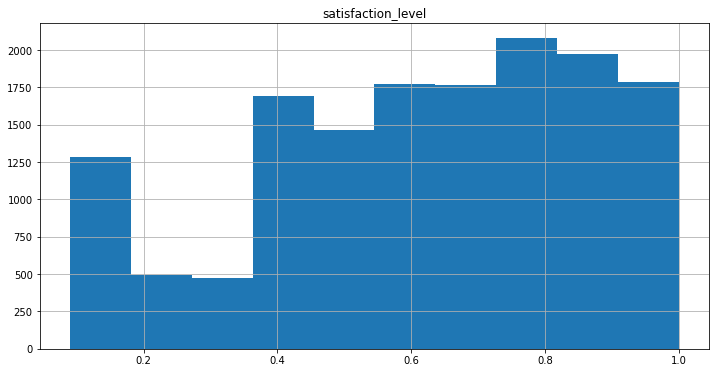

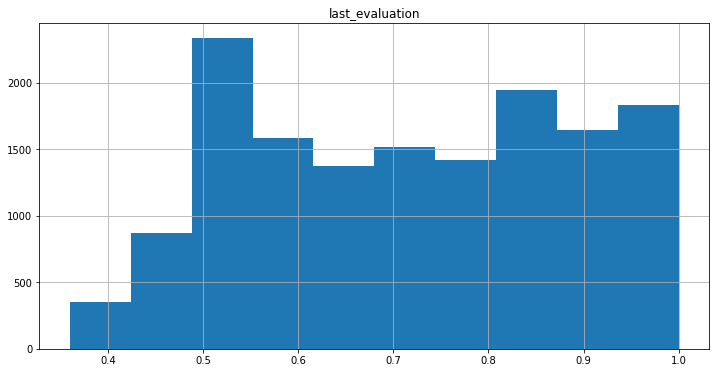

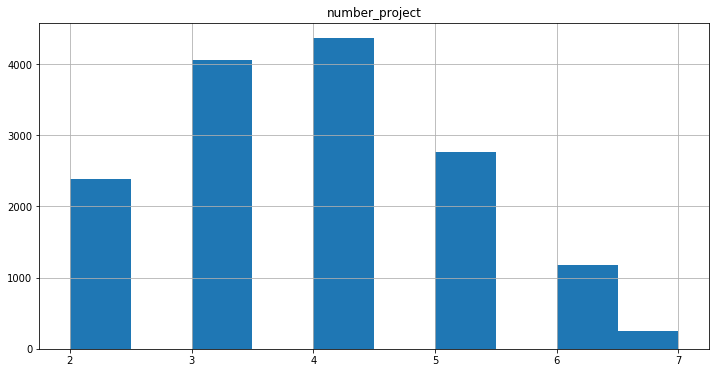

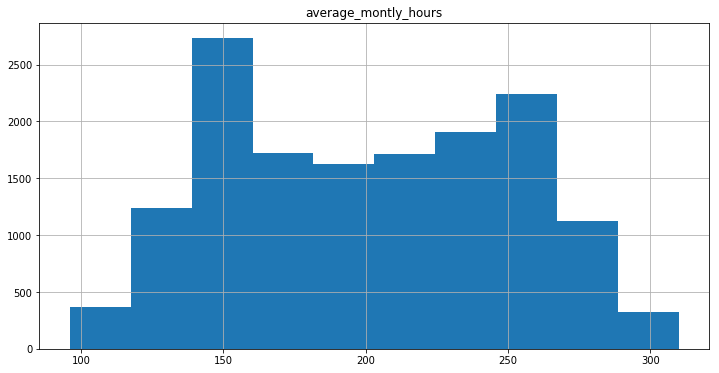

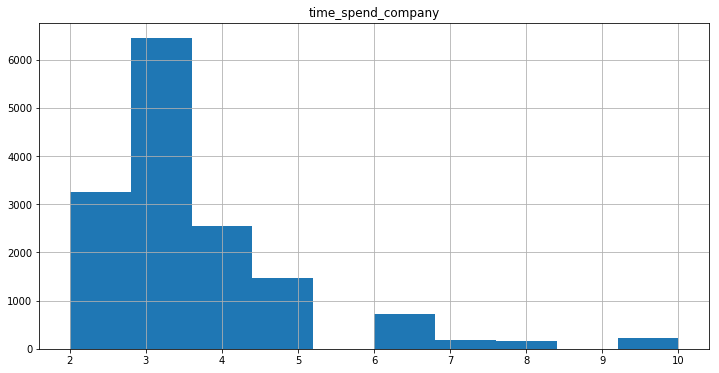

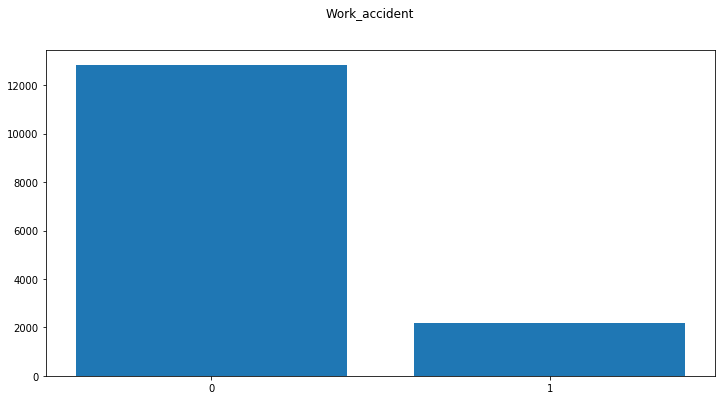

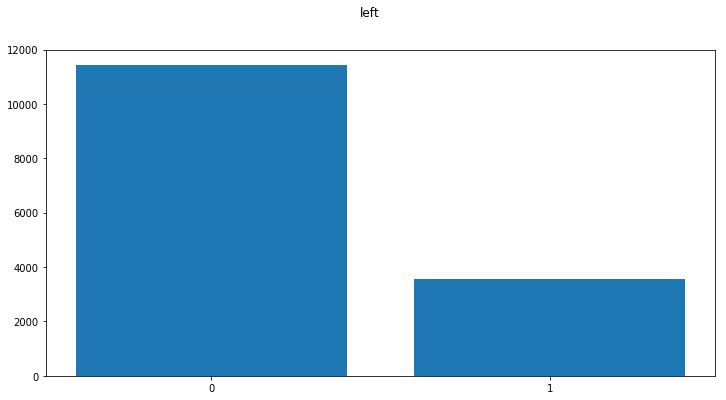

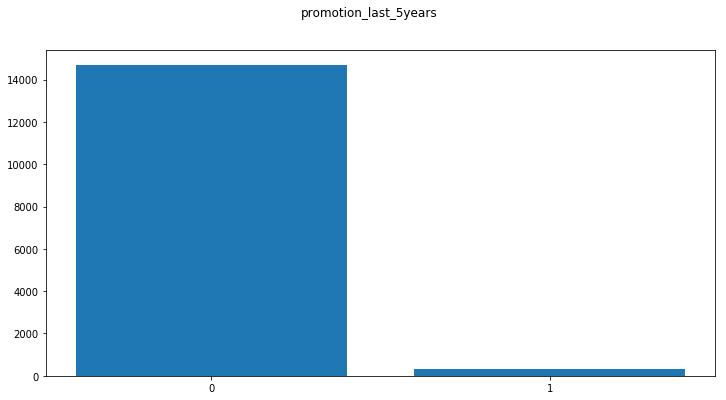

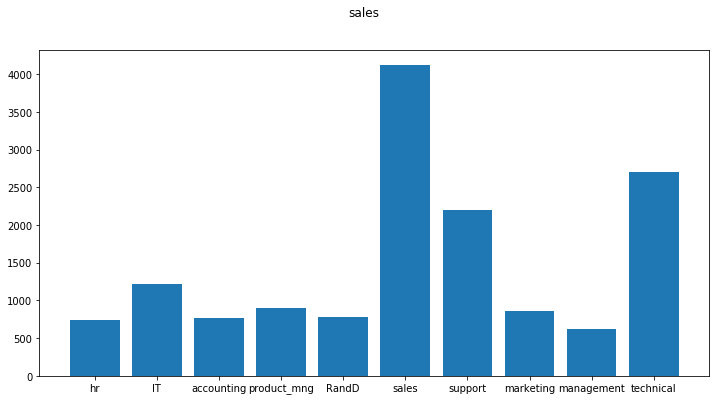

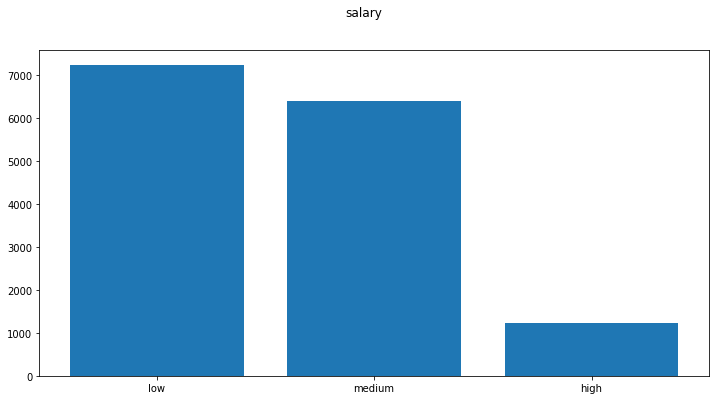

In [73]:
for c in hr_data.columns:
    column = set(hr_data[c].dropna())
    if is_interval_or_ratio(column):
        hr_data.hist(c, figsize=(12,6))
    else:
        fig = plt.figure(figsize=(12,6))
        counts = {str(s): len(hr_data.query('{} == "{}"'.format(c, s))) for s in column}
        plt.bar(counts.keys(), counts.values())
        fig.suptitle(c)

## Outlier
Lagi-lagi, untuk atribut data nominal atau ordinal seperti `sales`, `salary`, `promotion_last_5years`, `left`, dan `work_accident`, outlier tidak dapat ditentukan.
Saya hanya visualisasikan outlier untuk atribut data interval dan rasio.

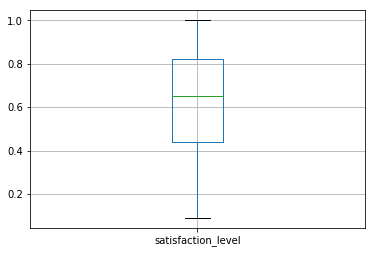

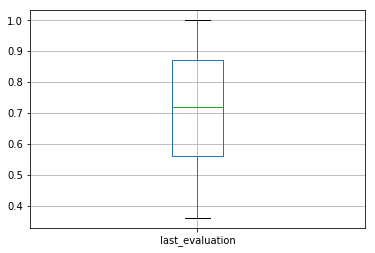

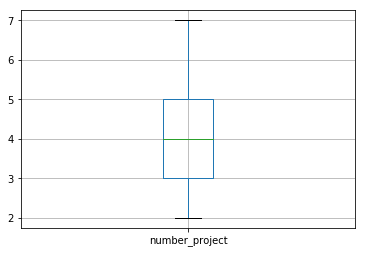

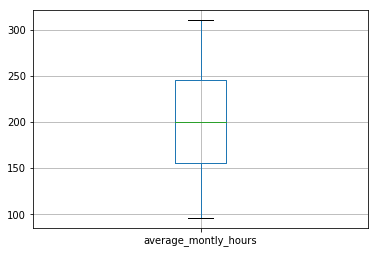

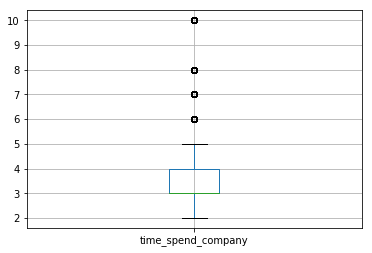

In [74]:
for c in hr_data.columns:
    column = set(hr_data[c].dropna())
    if is_interval_or_ratio(column):
        plt.figure()
        hr_data.boxplot(c)

Hanya atribut `time_spend_company` saja yang memiliki outlier

## Pemisahan kolom fitur dan label target
Pemisahan kolom fitur dan kolom label

In [89]:
hr_data = pd.read_csv('hr_data.csv')
feature_columns = [c for c in hr_data.columns if c != 'left']
X = hr_data[feature_columns]
y = hr_data.left

Pada tahap ini soal menginstruksikan untuk memisah data test dan training

*TAPI* data test juga perlu preprocessing ***agar bisa dipakai untuk menguji model klasifikasi***

Jadi dipisah nanti saja, sebelum normalisasi

## Pengisian missing values pada data training

In [90]:
X = pd.DataFrame({**{
        c: X[c].fillna(X[c].median()) for c in X.columns if is_interval_or_ratio(set(X[c].dropna()))
    }, **{
        c: X[c].fillna('KOSONG') for c in X.columns if not is_interval_or_ratio(set(X[c].dropna()))
    }
})

Cek apakah label mengandung missing value

In [91]:
assert len(y) == len(y.dropna())

## Handling data categorical

In [92]:
categorical_columns = ['sales', 'salary']
for cc in categorical_columns:
    X = X.join(pd.get_dummies(X[cc], prefix=cc))
numerical_columns = [c for c in X.columns if c not in categorical_columns]
X = X[numerical_columns]

In [93]:
X[:5]

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,promotion_last_5years,sales_IT,sales_KOSONG,sales_RandD,...,sales_management,sales_marketing,sales_product_mng,sales_sales,sales_support,sales_technical,salary_KOSONG,salary_high,salary_low,salary_medium
0,0.65,0.53,2,157,3,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
1,0.80,0.86,5,262,6,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
2,0.11,0.72,7,272,4,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
3,0.72,0.87,5,223,5,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
4,0.37,0.52,2,159,3,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0


## Normalisasi
Sekarang saya akan pisahkan data training dan data testing

In [95]:
X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=0.3)

In [96]:
scaler_train = StandardScaler()
X_train = scaler_train.fit_transform(X_train)

Saya gunakan scaler yang sama dengan training agar normalisasi data testing menyesuaikan distribusi data training

In [97]:
X_test = scaler_train.transform(X_test)

## Klasifikasi

### Logistic Regression

In [98]:
logistic_model = LogisticRegression()

In [99]:
logistic_model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [100]:
logistic_model.score(X_train, y_train)

0.792646918754167

In [101]:
logistic_model.score(X_test, y_test)

0.7875555555555556

Akurasi logistic regression
Akurasi AdaBoost classifer
- Training: 79.3%
- Testing: **78.8**

### Random Forest Classifier

In [45]:
random_forest_model = RandomForestClassifier()

In [46]:
random_forest_model.fit(X_train, y_train)

C:\Users\yerla\AppData\Local\conda\conda\envs\dsa\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [47]:
random_forest_model.score(X_train, y_train)

0.9983807981712544

In [48]:
random_forest_model.score(X_test, y_test)

0.9666666666666667

Akurasi random forest classifer
Akurasi AdaBoost classifer
- Training: 99.9%
- Testing: **96.7**

### AdaBoost Classifier

In [49]:
adaboost_model = AdaBoostClassifier()

In [50]:
adaboost_model.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)

In [51]:
adaboost_model.score(X_train, y_train)

0.9576150109534242

In [52]:
adaboost_model.score(X_test, y_test)

0.9404444444444444

Akurasi AdaBoost classifer
- Training: 95.8%
- Testing: **94.0**

## Visualisasi salah satu estimator Random Forest Classifier

In [57]:
estimator = random_forest_model.estimators_[0]

In [58]:
export_graphviz(estimator, 
                out_file='tree.dot', 
                feature_names = X.columns,
                class_names = 'left',
                rounded = True, proportion = False, 
                precision = 2, filled = True)

In [59]:
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

0

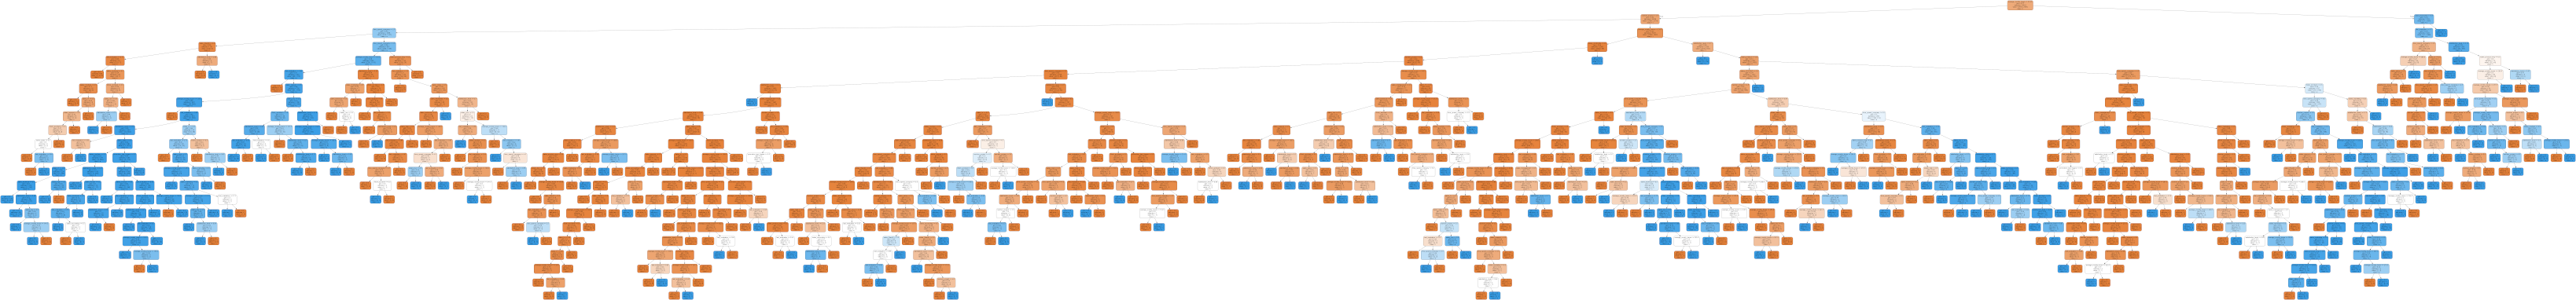

In [44]:
Image(filename = 'tree_lowres.png')

## GridSearchCV Hyperparameter Tuning

In [15]:
def hyper_param_tuning(estimator, grid, verbose=0):
    cv = GridSearchCV(estimator,grid, cv=5, verbose=verbose)
    cv.fit(X_train, y_train)
    print('train', cv.best_estimator_.score(X_train,y_train))
    print('test', cv.best_estimator_.score(X_test,y_test))
    print(cv.best_params_)

### Logistic Regression Hyperparameter Tuning

In [38]:
hyper_param_tuning(LogisticRegression(), {
    'C':np.logspace(-3,3,7), 'solver':['lbfgs', 'newton-cg', 'saga'], 'max_iter': [20,50,100]
})

train 0.7855033812744071
test 0.7873333333333333
{'C': 1000.0, 'max_iter': 100, 'solver': 'lbfgs'}


Akurasi logistic regression terbaik

- Training: 78.5%
- Testing: **78.7%**

Parameter terbaik:

| Nama Parameter | kandidat   | terbaik |
|------------------------------------|-----------------------------------------|--------|
|   Inverse Regularization Strength  | .001, .01, .1, 1, 10, 100, 1000         | 1000   |
|   Max Iteration                    |   20, 50, 100                           | 100    |
|   Solver                           | Newton Conjugate Gradient, L-BFGS, SAGA | L-BFGS |

### Random Forest Classifier Hyperparameter Tuning

In [35]:
hyper_param_tuning(RandomForestClassifier(), {'n_estimators': [10, 20, 50]})

train 0.9993332698352224
test 0.9844444444444445
{'n_estimators': 20}


Akurasi random forest classifier terbaik

- Training: 99.9%
- Testing: **98.4%**

Parameter terbaik:

| Nama Parameter | kandidat   | terbaik |
|-------------------------|-------------|------|
|   Number of estimators  | 10, 20, 50  | 20   |

### AdaBoost Classifier Hyperparameter Tuning

In [17]:
hyper_param_tuning(AdaBoostClassifier(), {
    'n_estimators': [10, 20, 50, 100],
    'learning_rate': [.6, .8, 1]
})

train 0.9609486617773121
test 0.9562222222222222
{'learning_rate': 0.8, 'n_estimators': 100}


Akurasi random forest classifier terbaik

- Training: 96.1%
- Testing: **95.6%**

Parameter terbaik:

| Nama Parameter          | kandidat         | terbaik |
|-------------------------|------------------|---------|
|   Number of estimators  | 10, 20, 50, 100  | 100     |
|   Learning rate         | .6, .8, 1        | .8      |

### Summary
| Algoritma Klasifikasi   | Akurasi test     |
|-------------------------|------------------|
|   Logistic Regression   | 78.7%            |
|   Random Forest         | **98.4%**        |
|   AdaBoost              | 95.6%            |

# Russian House Pricing

## Load Data Training

In [3]:
house_train = pd.read_csv(
    'train.csv',
    parse_dates=['timestamp'],
)

In [4]:
house_train.head()

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,...,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc
0,1,2011-08-20,43,27.0,4.0,NaN,NaN,NaN,NaN,NaN,...,9,4,0,13,22,1,0,52,4,5850000
1,2,2011-08-23,34,19.0,3.0,NaN,NaN,NaN,NaN,NaN,...,15,3,0,15,29,1,10,66,14,6000000
2,3,2011-08-27,43,29.0,2.0,NaN,NaN,NaN,NaN,NaN,...,10,3,0,11,27,0,4,67,10,5700000
3,4,2011-09-01,89,50.0,9.0,NaN,NaN,NaN,NaN,NaN,...,11,2,1,4,4,0,0,26,3,13100000
4,5,2011-09-05,77,77.0,4.0,NaN,NaN,NaN,NaN,NaN,...,319,108,17,135,236,2,91,195,14,16331452


Apabila tanpa `parse_dates`

In [5]:
d = pd.read_csv('train.csv')
d.head()

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,...,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc
0,1,2011-08-20,43,27.0,4.0,NaN,NaN,NaN,NaN,NaN,...,9,4,0,13,22,1,0,52,4,5850000
1,2,2011-08-23,34,19.0,3.0,NaN,NaN,NaN,NaN,NaN,...,15,3,0,15,29,1,10,66,14,6000000
2,3,2011-08-27,43,29.0,2.0,NaN,NaN,NaN,NaN,NaN,...,10,3,0,11,27,0,4,67,10,5700000
3,4,2011-09-01,89,50.0,9.0,NaN,NaN,NaN,NaN,NaN,...,11,2,1,4,4,0,0,26,3,13100000
4,5,2011-09-05,77,77.0,4.0,NaN,NaN,NaN,NaN,NaN,...,319,108,17,135,236,2,91,195,14,16331452


Sekilas tak ada bedanya, tapi apabila ditelusuri lebih lanjut:

In [6]:
house_train.timestamp[0]

Timestamp('2011-08-20 00:00:00')

In [7]:
d.timestamp[0]

'2011-08-20'

## Load Data Testing dan Merge dengan Data Ekonomi Makro

In [8]:
house_test = pd.read_csv(
    'test.csv',
    parse_dates=['timestamp'],
)

In [9]:
house_train_test = pd.concat([house_train, house_test])

In [10]:
macro = pd.read_csv(
    'macro.csv',
    parse_dates=['timestamp'],
)

In [11]:
russian_house_price = house_train_test.merge(macro, left_on='timestamp', right_on='timestamp')
russian_house_price.head()

,0_13_all,0_13_female,0_13_male,0_17_all,0_17_female,0_17_male,0_6_all,0_6_female,0_6_male,16_29_all,...,provision_retail_space_modern_sqm,turnover_catering_per_cap,theaters_viewers_per_1000_cap,seats_theather_rfmin_per_100000_cap,museum_visitis_per_100_cap,bandwidth_sports,population_reg_sports_share,students_reg_sports_share,apartment_build,apartment_fund_sqm
0,18654,8945,9709,23603,11317,12286,9576,4677,4899,17508,...,271.0,6943.0,565.0,0.45356,1240.0,269768.0,22.37,64.12,23587.0,230310.0
1,13729,6800,6929,17700,8702,8998,6880,3414,3466,15164,...,271.0,6943.0,565.0,0.45356,1240.0,269768.0,22.37,64.12,23587.0,230310.0
2,11252,5336,5916,14884,7063,7821,5879,2784,3095,19401,...,271.0,6943.0,565.0,0.45356,1240.0,269768.0,22.37,64.12,23587.0,230310.0
3,24934,12152,12782,32063,15550,16513,13087,6442,6645,3292,...,271.0,6943.0,565.0,0.45356,1240.0,269768.0,22.37,64.12,23587.0,230310.0
4,11631,5408,6223,15237,7124,8113,5706,2724,2982,5164,...,271.0,6943.0,565.0,0.45356,1240.0,269768.0,22.37,64.12,23587.0,230310.0


## Pemisahan kolom fitur dan label target
Pemisahan kolom fitur dan kolom label

`id` bukanlah fitur

`timestamp` pun juga bukanlah fitur yang menurut saya dapat digunakan secara mentah-mentah,
daripada rumit mengurus preprocessingnya, lebih baik tidak diikutsertakan dulu

In [12]:
rhp_feature_columns = [c for c in russian_house_price.columns if c not in ('price_doc', 'id', 'timestamp')]
rhp_X = russian_house_price[rhp_feature_columns]
rhp_y = russian_house_price.price_doc

Pada tahap ini soal menginstruksikan untuk memisah data test dan training

*TAPI* data test juga perlu preprocessing ***agar bisa dipakai untuk menguji model klasifikasi***

Jadi dipisah nanti saja, sebelum normalisasi

## Perbaikan format penulisan angka yang salah
Perhatikan kolom berikut

In [13]:
set(rhp_X.modern_education_share.dropna())

{'90,92', '93,08', '95,4918'}

Tipe datanya adalah `string` karena ada tanda kutipnya, akan saya perbaiki terlebih dahulu data yang `merepotkan` seperti ini.

In [14]:
is_float_but_wrongformat = lambda s: bool(type(s) == str and re.match(r'^\d+,\d+$', s))

In [15]:
rhp_X = pd.DataFrame({
    c: [float(v.replace(',', '.')) if is_float_but_wrongformat(v) else v for v in rhp_X[c]]
    for c in rhp_X.columns
})

## Perbaikan format data yang tidak masuk akal
Perhatikan kolom berikut

In [16]:
set(rhp_X.child_on_acc_pre_school.dropna())

{'#!', 16.765, 3.013, 7.311}

Yaampun, apa artinya `#!` ???

Akan saya ubah jadi NaN

In [17]:
rhp_X.child_on_acc_pre_school = pd.Series([
    v if type(v) == float else np.nan for v in rhp_X.child_on_acc_pre_school
])

## Pengisian missing values pada data

In [18]:
rhp_X = pd.DataFrame({**{
        c: rhp_X[c].fillna(rhp_X[c].median()) for c in rhp_X.columns if is_interval_or_ratio(set(rhp_X[c].dropna()))
    }, **{
        c: rhp_X[c].fillna('KOSONG') for c in rhp_X.columns if not is_interval_or_ratio(set(rhp_X[c].dropna()))
    }
})

Cek apakah label mengandung missing value

In [19]:
len(rhp_y) - len(rhp_y.dropna())

7662

Ternyata terdapat missing value pada label, saya akan isi dengan median

In [20]:
rhp_y = rhp_y.fillna(rhp_y.median())

## Handling data categorical
Pertama, cari tahu dulu kolom mana saja yang categorical

Fungsi `is_interval_or_ratio` yang saya buat mungkin masih belum akurat

In [21]:
rhp_categorical_columns = []
for c in rhp_X.columns:
    if not is_interval_or_ratio(set(rhp_X[c])):
        rhp_categorical_columns.append(c)
        print(c, set(rhp_X[c]))

big_market_raion {'yes', 'no'}
big_road1_1line {'yes', 'no'}
culture_objects_top_25 {'yes', 'no'}
detention_facility_raion {'yes', 'no'}
ecology {'poor', 'excellent', 'satisfactory', 'no data', 'good'}
incineration_raion {'yes', 'no'}
mosque_count_1000 {0, 1}
mosque_count_1500 {0, 1}
mosque_count_2000 {0, 1}
mosque_count_3000 {0, 1, 2}
mosque_count_500 {0, 1}
mosque_count_5000 {0, 1, 2}
nuclear_reactor_raion {'yes', 'no'}
oil_chemistry_raion {'yes', 'no'}
product_type {'OwnerOccupier', 'Investment', 'KOSONG'}
radiation_raion {'yes', 'no'}
railroad_1line {'yes', 'no'}
railroad_terminal_raion {'yes', 'no'}
school_education_centers_top_20_raion {0, 1, 2}
sub_area {'Horoshevskoe', "Altuf'evskoe", 'Vojkovskoe', 'Arbat', 'Obruchevskoe', 'Fili Davydkovo', "Mar'ino", 'Severnoe Izmajlovo', 'Butyrskoe', 'Vostochnoe Izmajlovo', 'Troparevo-Nikulino', 'Teplyj Stan', 'Staroe Krjukovo', 'Preobrazhenskoe', 'Danilovskoe', 'Ochakovo-Matveevskoe', 'Vyhino-Zhulebino', 'Otradnoe', 'Rostokino', 'Hamovniki',

`Mosque count` nampaknya bukan categorical.

Untuk `school_education_centers_top_20_raion`, saya tidak yakin apakah itu categorical atau bukan.
Pada kasus ini, akan saya asumsikan categorical.

In [22]:
rhp_categorical_columns = [c for c in rhp_categorical_columns if c.find('mosque') < 0]
rhp_categorical_columns

['big_market_raion',
 'big_road1_1line',
 'culture_objects_top_25',
 'detention_facility_raion',
 'ecology',
 'incineration_raion',
 'nuclear_reactor_raion',
 'oil_chemistry_raion',
 'product_type',
 'radiation_raion',
 'railroad_1line',
 'railroad_terminal_raion',
 'school_education_centers_top_20_raion',
 'sub_area',
 'thermal_power_plant_raion',
 'water_1line']

In [23]:
for cc in rhp_categorical_columns:
    rhp_X = rhp_X.join(pd.get_dummies(rhp_X[cc], prefix=cc))
numerical_columns = [c for c in rhp_X.columns if c not in rhp_categorical_columns]
rhp_X = rhp_X[numerical_columns]

In [24]:
rhp_X.head()

,0_13_all,0_13_female,0_13_male,0_17_all,0_17_female,0_17_male,0_6_all,0_6_female,0_6_male,16_29_all,...,sub_area_Vostochnoe Izmajlovo,sub_area_Vyhino-Zhulebino,sub_area_Zamoskvorech'e,sub_area_Zapadnoe Degunino,sub_area_Zjablikovo,sub_area_Zjuzino,thermal_power_plant_raion_no,thermal_power_plant_raion_yes,water_1line_no,water_1line_yes
0,18654,8945,9709,23603,11317,12286,9576,4677,4899,17508,...,0,0,0,0,0,0,1,0,1,0
1,13729,6800,6929,17700,8702,8998,6880,3414,3466,15164,...,0,0,0,0,0,0,1,0,1,0
2,11252,5336,5916,14884,7063,7821,5879,2784,3095,19401,...,0,0,0,0,0,0,1,0,1,0
3,24934,12152,12782,32063,15550,16513,13087,6442,6645,3292,...,0,0,0,0,0,0,1,0,1,0
4,11631,5408,6223,15237,7124,8113,5706,2724,2982,5164,...,0,0,0,0,0,0,1,0,1,0


## Normalisasi
Sekarang saya akan pisahkan data training dan data testing

In [25]:
rhp_X_train, rhp_X_test, rhp_y_train, rhp_y_test=train_test_split(np.array(rhp_X),np.array(rhp_y),test_size=0.3)

In [26]:
scaler_train_rhp = StandardScaler()
rhp_X_train = scaler_train_rhp.fit_transform(rhp_X_train)

Saya gunakan scaler yang sama dengan training agar normalisasi data testing menyesuaikan distribusi data training

In [27]:
rhp_X_test = scaler_train_rhp.transform(rhp_X_test)

## Regression

In [28]:
def smape(A, F):
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

In [29]:
def plot_regression(actual, pred):
    print('Root Mean Squared Error:', np.sqrt(mean_squared_error(actual, pred)))
    print('Mean Absolute Error:', mean_absolute_error(actual, pred))
    print('Symmetric Mean Absolute Percentage Error:', smape(actual, pred), '%')
    plt.figure(figsize=(12,6))
    plt.plot(actual[:50])
    plt.plot(pred[:50])
    plt.legend(['actual', 'prediction'])
    print('Plot is only for first 50 values')

In [30]:
def regression(model):
    model.fit(rhp_X_train, rhp_y_train)
    y_pred = model.predict(rhp_X_test)
    plot_regression(rhp_y_test, y_pred)
    return y_pred

### Linear Regression

Root Mean Squared Error: 614931850539050.8
Mean Absolute Error: 5749288661392.317
Symmetric Mean Absolute Percentage Error: 26.753194121146283 %
Plot is only for first 50 values


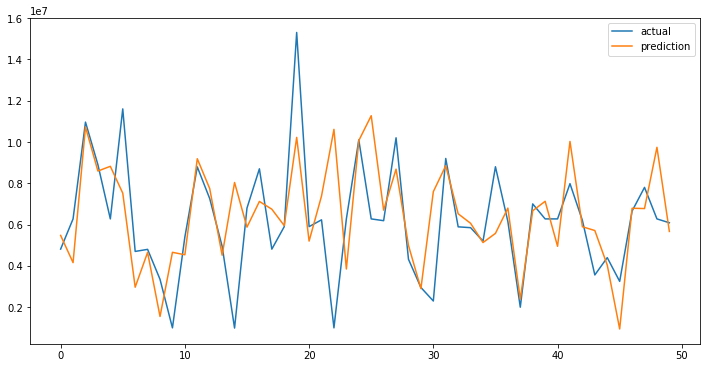

In [296]:
rhp_y_pred = regression(LinearRegression())

### Lasso

Root Mean Squared Error: 5378630.719908447
Mean Absolute Error: 1836622.9619320056
Symmetric Mean Absolute Percentage Error: 26.79161260898751 %
Plot is only for first 50 values


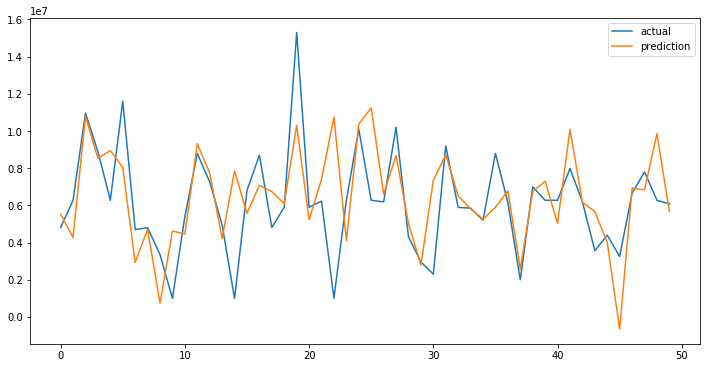

In [293]:
rhp_y_pred = regression(Lasso())

### Ridge

Root Mean Squared Error: 5374457.539441577
Mean Absolute Error: 1836884.2551434257
Symmetric Mean Absolute Percentage Error: 26.801972560722405 %
Plot is only for first 50 values


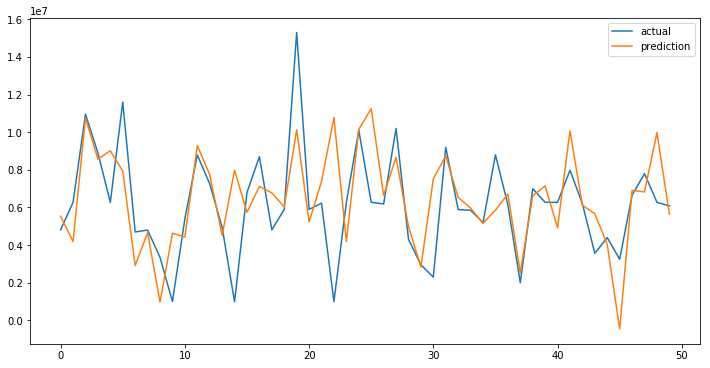

In [294]:
rhp_y_pred = regression(Ridge())

## Feature Engineering
Saya membuang beberapa kolom dan mengkonversi bentuk data beberapa kolom sesuai dengan yang saya jelaskan di atas

## Hyperparameter Tuning

In [31]:
def hyper_param_tuning_regression(estimator, grid, verbose=0):
    cv = GridSearchCV(estimator,grid, cv=5, verbose=verbose)
    cv.fit(rhp_X_train, rhp_y_train)
    y_pred = cv.predict(rhp_X_test)
    plot_regression(rhp_y_test, y_pred)
    print(cv.best_params_)

### Linear Regression Hyperparameter Tuning
Tidak perlu ada hyperparameter tuning untuk linear regression.

Tidak ada parameter tambahan untuk linear regression.

### Lasso Hyperparameter Tuning

Root Mean Squared Error: 5449134.144063425
Mean Absolute Error: 1844103.3118130364
Symmetric Mean Absolute Percentage Error: 26.83227828048627 %
Plot is only for first 50 values
{'alpha': 1, 'max_iter': 10}


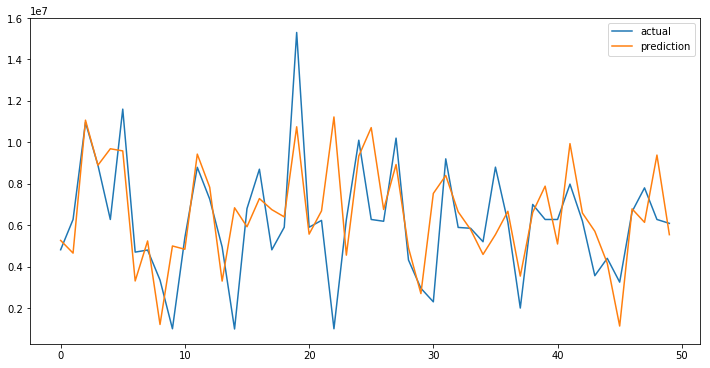

In [301]:
hyper_param_tuning_regression(Lasso(), {
    'alpha':[.7, .85, 1], 'max_iter': [10, 20,50,100]
})

Akurasi Lasso regression terbaik

- Testing SMAPE: **26.8%**

Parameter terbaik:

| Nama Parameter   | kandidat        | terbaik |
|------------------|-----------------|---------|
|   Alpha          | .7, .85, 1      | 1       |
|   Max Iteration  | 10, 20, 50, 100 | 10      |

### Ridge Hyperparameter Tuning

Root Mean Squared Error: 14638297.963580072
Mean Absolute Error: 2077227.4833182702
Symmetric Mean Absolute Percentage Error: 28.4893169513146 %
Plot is only for first 50 values
{'max_iter': 30, 'solver': 'saga'}


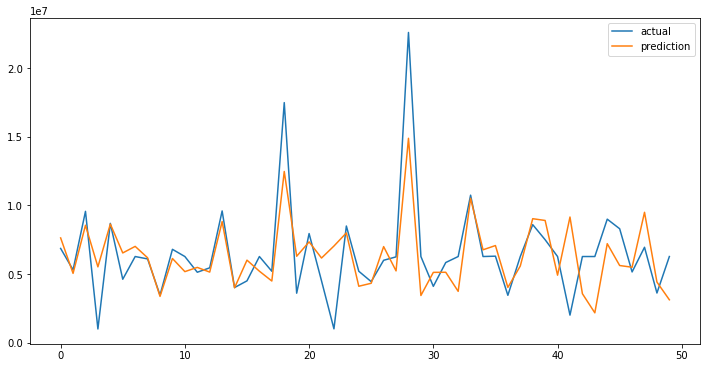

In [33]:
hyper_param_tuning_regression(Ridge(), {
    'max_iter': [30],
    'solver': ['svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']
}, verbose=0)

Akurasi Ridge regression terbaik

- Testing SMAPE: **28.5%**

Parameter terbaik:

| Nama Parameter   | kandidat        | terbaik |
|------------------|-----------------|---------|
|   Solver         | SVD, Cholesky, Least Square, Conjugate Gradient, Stochastic Average Gradient Descent, Stochastic Average Gradient Descent SAGA      | SAGA       |

# Movies

## Load Data

In [8]:
movies = pd.read_csv('movies_metadata.csv')
movies.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [9]:
movies.original_title[35585]

"Angels' Alley"

In [10]:
movies.original_title[29502]

'マルドゥック・スクランブル 排気'

In [11]:
movies.original_title[19730]

"[{'iso_639_1': 'en', 'name': 'English'}]"

In [12]:
movies = movies.drop(35585)
movies = movies.drop(29502)
movies = movies.drop(19730)

### Reduksi Dimensi
Kolom yang *redundant* dapat dihilangkan, seperti:
- `release_date` dan `status` , cukup release_date saja
- `adult` bisa dihapus, dipindah ke `genre` saja

## Persiapan data untuk Clustering

In [13]:
movies_metrics = movies[['title', 'budget', 'popularity', 'revenue', 'runtime', 'vote_average', 'vote_count']]
movies_metrics.head()

,title,budget,popularity,revenue,runtime,vote_average,vote_count
0,Toy Story,30000000,21.9469,373554033.0,81.0,7.7,5415.0
1,Jumanji,65000000,17.0155,262797249.0,104.0,6.9,2413.0
2,Grumpier Old Men,0,11.7129,0.0,101.0,6.5,92.0
3,Waiting to Exhale,16000000,3.85949,81452156.0,127.0,6.1,34.0
4,Father of the Bride Part II,0,8.38752,76578911.0,106.0,5.7,173.0


In [14]:
movies_metrics.vote_count.describe()

count    45459.000000
mean       109.899734
std        491.315512
min          0.000000
25%          3.000000
50%         10.000000
75%         34.000000
max      14075.000000
Name: vote_count, dtype: float64

```python
movies_metrics.vote_count.describe()
```
Menjelaskan jumlah non-null value, mean, standard deviation, nilai minimum dan maximum, dan persentil

## Sampling

In [15]:
len(movies_metrics)

45463

Ukuran data (45463) **relatif kecil** untuk diproses komputer jaman sekarang.

Maka dari itu, untuk diolah lebih lanjut, ***tidak perlu sampling lagi***, gunakan saja semuanya.


## Clustering
Pertama, buang data yang jumlah vote nya sedikit (< 30)

In [16]:
movies_metrics = movies_metrics.query('vote_count >= 30')
len(movies_metrics)

12421

## Handling Missing Values

In [17]:
feature_columns = [c for c in movies_metrics.columns if c != 'title']

In [18]:
movies_metrics = pd.DataFrame({**{
        c: movies_metrics[c].fillna(movies_metrics[c].median()) for c in feature_columns
    }, **{
        'title': movies_metrics.title
    }
})

### Normalisasi MinMax

In [19]:
scaler_movies = MinMaxScaler()

In [20]:
unscaled_movies_metrics = movies_metrics.copy()
movies_metrics[feature_columns] = scaler_movies.fit_transform(movies_metrics[feature_columns])
movies_metrics.head()

,budget,popularity,revenue,runtime,vote_average,vote_count,title
0,0.078947,0.040082,0.133988,0.092360,0.810526,0.383410,Toy Story
1,0.171053,0.031075,0.094261,0.118586,0.726316,0.169669,Jumanji
2,0.000000,0.021389,0.000000,0.115165,0.684211,0.004414,Grumpier Old Men
3,0.042105,0.007045,0.029216,0.144812,0.642105,0.000285,Waiting to Exhale
4,0.000000,0.015315,0.027468,0.120867,0.600000,0.010182,Father of the Bride Part II


## Elbow Curve K-Means

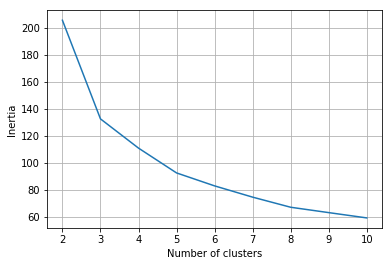

In [21]:
k_range = range(2, 11)
ks = []
scores = []
for k in k_range:
    km = KMeans(n_clusters=k, random_state=1)
    km.fit(movies_metrics[feature_columns])
    ks.append(km)
    scores.append(km.inertia_)
# plot the results
plt.plot(k_range, scores)
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.grid(True)

Dilihat dari *elbow curve*, `k` optimum adalah `k=3`

## Visualisasi Cluster

In [22]:
clusters = ks[1]
cluster_count = [0, 0, 0]
for label in clusters.labels_:
    cluster_count[label] += 1

### Cluster Summary

<BarContainer object of 3 artists>

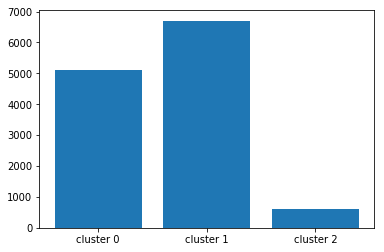

In [23]:
plt.bar(['cluster 0', 'cluster 1', 'cluster 2'], cluster_count)

In [24]:
cluster_count

[5096, 6704, 621]

- Terdapat 5096 film pada cluster 0
- Terdapat 6704 film pada cluster 0
- Terdapat 621 film pada cluster 0

### Scatter Plot
Hanya 1000 titik pertama

In [25]:
choose_color = lambda label: ['r', 'g', 'b'][label]

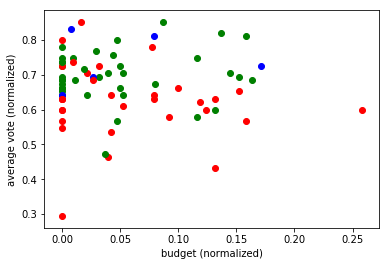

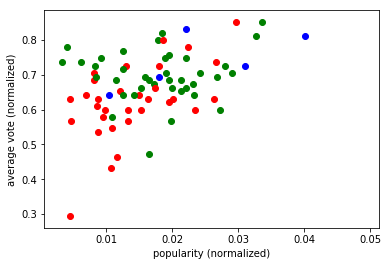

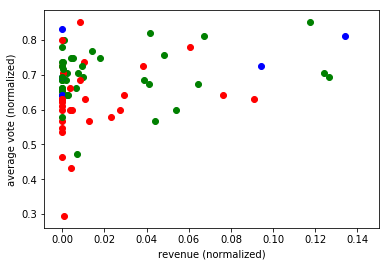

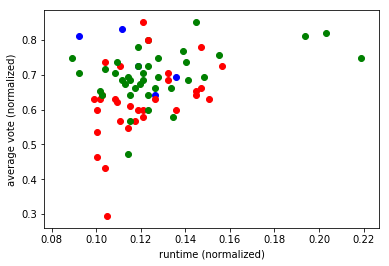

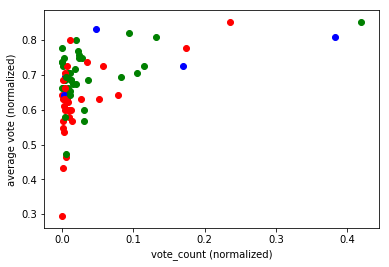

In [28]:
for c in [col for col in feature_columns if col != 'vote_average']:
    plt.figure()
    for i in range(1000):
        try:
            plt.scatter(movies_metrics[c][i], movies_metrics.vote_average[i], color=choose_color(clusters.labels_[i]))
            plt.xlabel('{} (normalized)'.format(c))
            plt.ylabel('average vote (normalized)')
        except:
            pass